In [19]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn import datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [20]:
# loading in dataset
data = pd.read_csv("win_prediction_data_clean.txt")
data

,win,map,Team_A_avg_win_percentage,Team_A_avg_KR,Team_A_avg_elo,Team_B_avg_win_percentage,Team_B_avg_KR,Team_B_avg_elo,Match ID
0,team a,de_mirage,58.864865,0.726308,1720.4,47.289216,0.792615,1536,1-051c5a18-6a99-4e5e-bef7-ed1143474b33
1,team a,de_inferno,52.341629,0.764807,1989.6,54.823232,0.762641,2073,1-8f29e3ec-f49d-4d05-8eac-98993126c405
2,team b,de_mirage,48.414652,0.733409,2565.0,62.631108,0.838246,2219,1-34674634-6bc9-45bc-b022-3f3161d5aede
3,team b,de_mirage,43.571196,0.709982,1484.4,55.513072,0.768946,1352,1-a9869c55-52a9-45a8-beb6-1fdffed4506d
4,team b,de_anubis,29.802198,0.596095,1443.4,45.317460,0.690571,1632,1-f4f59665-2fb0-46e9-a617-7003bb038bc2
...,...,...,...,...,...,...,...,...,...
9646,team b,de_dust2,37.216864,0.708777,2263.2,56.472292,0.692718,2324,1-0acb19d7-9a6e-45b2-a39b-eeaf9ce70bf6
9647,team a,de_mirage,51.786727,0.805856,1954.8,55.834695,0.804215,2119,1-75368039-7806-4238-99dd-2f2a11d9a5a7
9648,team b,de_vertigo,43.787879,0.736561,1814.6,61.140351,0.745579,2127,1-021380c3-2ae6-48fd-917d-dc4541535140
9649,team b,de_mirage,42.260784,0.748870,1723.2,57.138047,0.816129,1625,1-f2d2bb0c-f16c-40f9-b3bc-7ba410249b9d


In [21]:
# Creating dummy classes for different maps
dummy_map = pd.get_dummies(data, columns = ["map"], drop_first = True)

# spliting features and response variable
features = dummy_map.drop(columns = ["win", "Match ID"]).astype(float)
                          
# transforming response column into a 1d array
response = data.loc[:, ["win"]].values.ravel()

# creating dummy variable
encoder = LabelEncoder()
dummy_response = encoder.fit_transform(response)

In [22]:
# splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, dummy_response, test_size = 0.2)

In [23]:
# creating tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [24]:
# intializing data into loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [25]:
# Check if CUDA is available, otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# hyperparameters
learning_rate = 0.0001

In [27]:
# defining model
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()

        # features layer
        self.features = nn.Sequential(
            nn.Linear(14, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
        )
    
    # Forward pass
    def forward(self, x):
        x = self.features(x)
        return x


In [31]:
def confidence_interval(accuracy, n = 9651, confidence = 0.95):
    p_hat = accuracy / 100 
    z = norm.ppf(1 - (1 - confidence) / 2)
    margin = z * np.sqrt((p_hat * (1 - p_hat)) / n)
    lower = p_hat - margin
    upper = p_hat + margin
    print(f"Confidence Interval: {lower * 100:.2f} | {accuracy:.2f} | {upper * 100:.2f}")

In [32]:
# defining function for training and validation for best epoch then finding test classification accuracy
def train_test_func(model_type = 0):
    # Initialize the model, loss function, and optimizer
    model = BinaryClassification().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-4)

    # lists to hold train loss and val accuracy
    train_loss_list = []
    val_accuracy_list = []

    # setting counters to find best epoch based on validation accuracy
    best_val_count = 0
    epoch_count = 0
    best_epoch = 0
    best_val_accuracy = 0

    # looping until validation accuracy does not improve over 5 iterations
    while best_val_count < 10:
        epoch_count += 1
        model.train()
        running_loss = 0.0
        for features, target in train_loader:
            # moving features & target to device
            features = features.to(device)
            target = target.to(device)
            # forward pass
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, target)
            # backpass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()



        # Calculating and appending train loss
        train_loss = running_loss / len(train_loader.dataset)
        train_loss_list.append(train_loss)

        if epoch_count % 5 == 0:
            print(f"Epoch [{epoch_count}], Training loss: {train_loss:.4f}")
        
        # Evaluation on validation set
        model.eval()
        correct = 0
        total = 0
        running_val_loss = 0.0
        with torch.no_grad():
            for features, target in val_loader:
                # moving features & target to device
                features = features.to(device)
                target = target.to(device)
                outputs = model(features).squeeze() # predicting class labels
                predict = (outputs > 0.5).float() # classifying outputs
                # calculating number of correct lables
                total += target.size(0)
                correct += (predict == target).sum().item()

            # Calculating and appending val accuracy
            val_accuracy = (correct/total) * 100
            val_accuracy_list.append(val_accuracy)

            # printing every 5 epochs
            if epoch_count % 5 == 0:
                print(f"Accuracy on the validation set: {val_accuracy:.2f}%")
                print()
    
        # Check if current val accuracy is better than previous best
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_val_count = 0
            best_epoch = epoch_count
            best_train_loss_list = train_loss_list[:]
            best_val_accuracy_list = val_accuracy_list[:]
            best_model_state = model.state_dict()  # Save best model
            
        else:
            best_val_count += 1
    
    print(f"Best Epoch [{best_epoch}], Best validation accuracy: {best_val_accuracy:.2f}%")
    confidence_interval(best_val_accuracy)
    
    # Plotting results
    sns.set(style="darkgrid")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot training
    axes[0].plot(range(1, best_epoch + 1), best_train_loss_list, label="Training Loss", marker="o")
    axes[0].set_xlabel("Number of Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training Loss")
    axes[0].legend()
    
    # Plot validation accuracy
    axes[1].plot(range(1, best_epoch + 1), best_val_accuracy_list, label="Validation Accuracy", marker="o", color="green")
    axes[1].set_xlabel("Number of Epochs")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].set_title("Validation Accuracy")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    

Epoch [5], Training loss: 0.0210
Accuracy on the validation set: 52.05%

Epoch [10], Training loss: 0.0179
Accuracy on the validation set: 63.13%

Epoch [15], Training loss: 0.0164
Accuracy on the validation set: 75.35%

Epoch [20], Training loss: 0.0160
Accuracy on the validation set: 74.83%

Epoch [25], Training loss: 0.0157
Accuracy on the validation set: 75.76%

Epoch [30], Training loss: 0.0156
Accuracy on the validation set: 75.82%

Epoch [35], Training loss: 0.0155
Accuracy on the validation set: 75.66%

Epoch [40], Training loss: 0.0155
Accuracy on the validation set: 76.28%

Epoch [45], Training loss: 0.0154
Accuracy on the validation set: 75.45%

Best Epoch [39], Best validation accuracy: 77.11%
Confidence Interval: 76.27 | 77.11 | 77.95


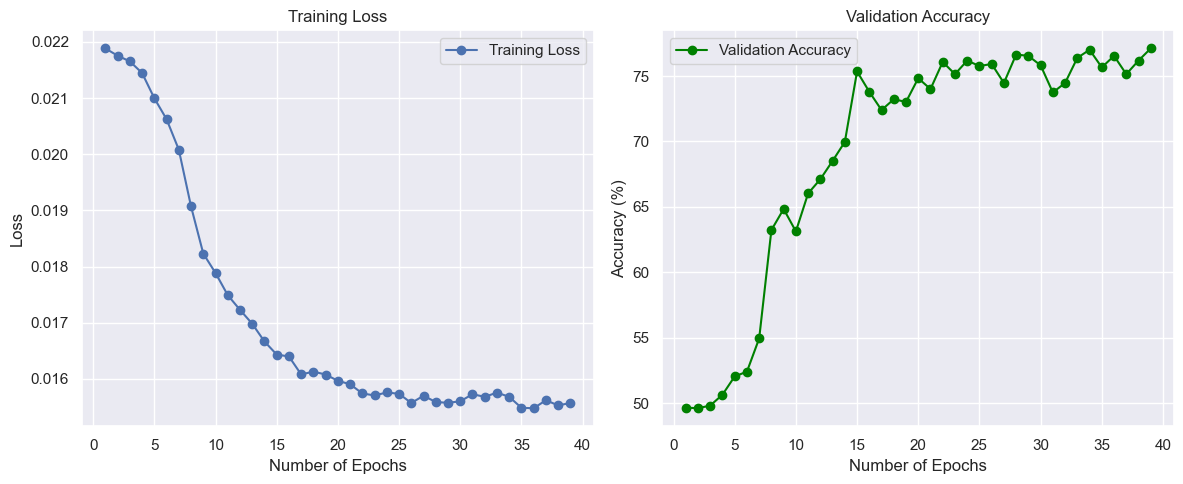

In [33]:
train_test_func()